In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import pendulum

df = pd.read_csv('energy_data_oak.csv')

df['hour_start_dt'] = pd.to_datetime(df['hour_start'])
dates_temp = [pendulum.datetime(x.year, x.month, x.day, x.hour, x.minute, tz='America/New_York') for x in df['hour_start_dt']]
df['hour_start_s'] = [int(x.timestamp()) for x in dates_temp]

df.drop(columns=['average_store_temp_end', 'average_buffer_temp_end', 'hour_start_dt'], inplace=True)

# Find all rows with the same storage and buffer start as the first row
target_store_temp = list(df['average_store_temp_start'])[0]
target_buffer_temp = list(df['average_buffer_temp_start'])[0]
filtered = df[
    (df['average_store_temp_start'] >= target_store_temp - 1) &
    (df['average_store_temp_start'] <= target_store_temp + 1) &
    (df['average_buffer_temp_start'] >= target_buffer_temp - 1) &
    (df['average_buffer_temp_start'] <= target_buffer_temp + 1)
]
display(filtered)

,hour_start,hp_elec_in,hp_heat_out,change_in_storage_and_buffer,implied_heat_load,average_store_temp_start,average_buffer_temp_start,hour_start_s
0,2025-01-01-00:00,0.71,1.02,-3.08,4.10,142.9,121.2,1735707600
2,2025-01-01-02:00,0.15,0.00,-2.86,2.86,143.7,120.5,1735714800
1159,2025-02-18-15:00,9.08,15.05,7.07,7.98,143.8,121.3,1739908800
1260,2025-02-23-05:00,7.64,13.77,5.81,7.96,143.5,121.3,1740304800
1591,2025-03-09-00:00,10.44,19.30,11.40,7.90,143.1,122.2,1741496400
1852,2025-03-19-22:00,0.19,0.00,-1.42,1.42,142.1,121.8,1742436000
2501,2025-04-16-01:00,7.71,17.37,11.55,5.82,142.0,120.7,1744779600


,hour_start,hp_heat_out,implied_heat_load,oat_f,ws_mph
0,2025-01-01-00:00,1.02,4.10,28.0,0.0
1,2025-01-01-01:00,9.03,5.45,27.0,0.0
2,2025-01-01-02:00,0.00,2.86,28.0,0.0
3,2025-01-01-03:00,9.50,6.58,28.0,0.0
4,2025-01-01-04:00,6.25,4.49,29.0,0.0
...,...,...,...,...,...
1841,2025-03-19-16:00,0.00,1.30,53.0,6.0
1842,2025-03-19-17:00,0.00,0.27,53.0,0.0
1843,2025-03-19-18:00,0.00,1.55,47.0,0.0
1844,2025-03-19-19:00,0.00,1.05,39.0,0.0


HP: 10920.93
Implied: 10940.5
Weather and parameters: 10783.905
Weather and parameters, scaled: 10920.93
Alpha: 9.3 -> 9.42
Beta: -0.17 -> -0.17
Alpha: 0.0015 -> 0.00152


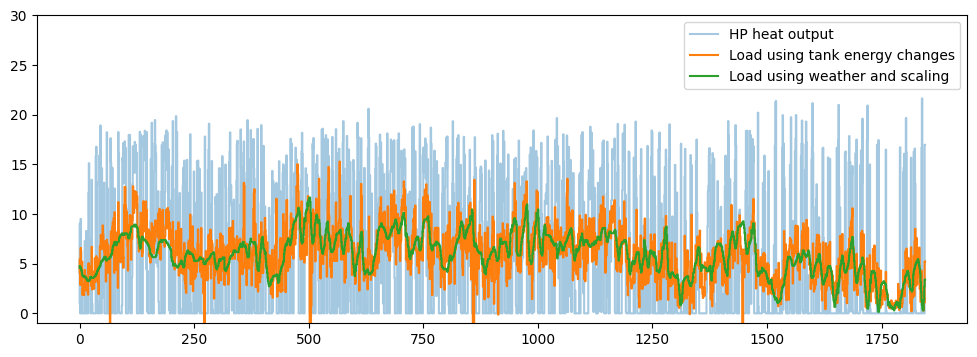

In [6]:
# Take the dataframe between two of those rows
df_same_start_and_end_state = df[:1852-1]

# Add weather data
weather_and_prices_df = pd.read_csv('simulation_data.csv')
final_df = pd.merge(df_same_start_and_end_state, weather_and_prices_df, on='hour_start_s', how='inner')
final_df = final_df[['hour_start', 'hp_heat_out', 'implied_heat_load', 'oat_f', 'ws_mph']]
display(final_df)

# Calculate load based on weather
SCADA_ALPHA=9.3
SCADA_BETA=-0.17
SCADA_GAMMA=0.0015
final_df['weather_load'] = SCADA_ALPHA + SCADA_BETA * final_df['oat_f'] + SCADA_GAMMA * final_df['ws_mph']

# Prints
total_hp_heat_out = round(sum(final_df['hp_heat_out']),3)
print(f"HP: {total_hp_heat_out}")
total_implied_heat_load = round(sum(final_df['implied_heat_load']),3)
print(f"Implied: {total_implied_heat_load}")
total_weather_load = round(sum(final_df['weather_load']),3)
print(f"Weather and parameters: {total_weather_load}")

# Scale weather based load
scaling_factor = total_weather_load/total_hp_heat_out
final_df['weather_load_scaled'] = final_df['weather_load'] / scaling_factor
total_weather_load_scaled = round(sum(final_df['weather_load_scaled']),3)
print(f"Weather and parameters, scaled: {total_weather_load_scaled}")
print(f"Alpha: {SCADA_ALPHA} -> {round(SCADA_ALPHA/scaling_factor,2)}")
print(f"Beta: {SCADA_BETA} -> {round(SCADA_BETA/scaling_factor,2)}")
print(f"Alpha: {SCADA_GAMMA} -> {round(SCADA_GAMMA/scaling_factor,5)}")

final_df_cropped = final_df[:100000]
plt.figure(figsize=(12,4))
plt.step(range(len(final_df_cropped)), final_df_cropped['hp_heat_out'], label='HP heat output', alpha=0.4)
plt.step(range(len(final_df_cropped)), final_df_cropped['implied_heat_load'], label='Load using tank energy changes')
plt.step(range(len(final_df_cropped)), final_df_cropped['weather_load_scaled'], label='Load using weather and scaling')
plt.legend()
plt.ylim([-1,30])
plt.show()